# Simplified mathematical model of the NPQ in DIATOMS

With this Notebook I aim to reproduce the behaviour of KEA3 mutants, observed by Claire and Giovanni.

Data visualised below.

#  Model
The model is based on the ETC model for Arabidopsis, as described in Matuszynska et al. 2016 [1].

[1] Matuszyńska, A., Heidari, S., Jahns, P., Ebenhöh, O., 2016. A mathematical model of non-photochemical quenching to study short-term light memory in plants. Biochimica et Biophysica Acta (BBA) - Bioenergetics 1857, 1860–1869. https://doi.org/10.1016/j.bbabio.2016.09.003)

### Assumptions
To account for the dynamics of diatoms we focus only on:
- PSII, H for pH and pmf, ATP and xantophylls.
(The overall change in the lumenal pH depends on the rate of photosystem II, cytochrome b6f, ATP synthase and proton leak)
- no LHX dependence, only xantophylls (Dd+Dt),
- quencher directly proportional to the Dt concentration,
- deepoxidation follows Hill kinetics, epoxidation governed by the mass action,
- KEA3 OE enhances the proton leak.

To be changed:
- lumen and stroma size similar. Hence the pool of PQ or ATP needs to be changed. Untill now stroma was assumed to be ~10 bigger than lumen. 3 pool sizes will have be re-scaled: PSII, PQ and ATP.
- I changed the mid point potential from 0.380 to 0.350

#### Conclusions after Wendesday work:
- forgotten kH0 in the fluorescence function in the previous models -> check how critical was it,
- don't see the impact of speeding up the leak -> shouldn't Q contribute to the change of lumenal H?.

[1] Matuszyńska, A., Heidari, S., Jahns, P., Ebenhöh, O., 2016. A mathematical model of non-photochemical quenching to study short-term light memory in plants. Biochimica et Biophysica Acta (BBA) - Bioenergetics 1857, 1860–1869. https://doi.org/10.1016/j.bbabio.2016.09.003)
 

## Import packages

In [203]:
import numpy as np
from modelbase.ode import Model, Simulator
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('ggplot')

plt.rcParams['figure.figsize'] = [15, 9]

In [204]:
%matplotlib notebook

## Visualise experimental data

In [205]:
folder = '/home/anna/ownCloud/diatom_Jun2020/'
ml_file = str(folder + 'NPQ ML LL norm.xlsx')
data_ml= pd.read_excel(ml_file)

hl_file = str(folder + 'NPQ HL LL norm.xlsx')
data_hl= pd.read_excel(hl_file)

raw_file = str(folder + 'Raw data.xlsx')
raw= pd.read_excel(raw_file)

In [206]:
# keep the same colour palette
colpal = {'Mutant 1': 'limegreen',
          'Mutant I': 'limegreen',
          'Mutant 2': 'darkgreen',
          'Mutant G': 'darkgreen',
          'WT': 'red',
          'Overexpressor': 'darkcyan'}

<IPython.core.display.Javascript object>


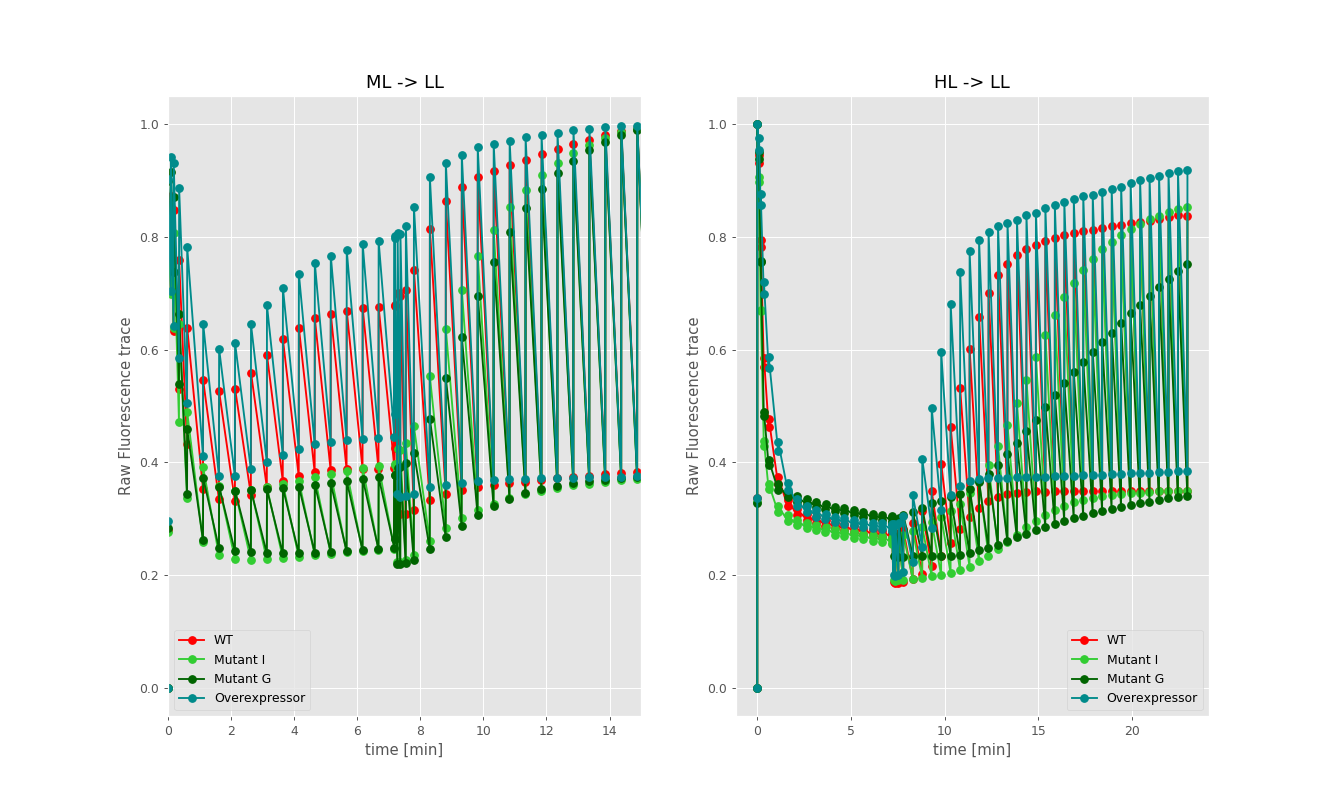

In [207]:
plt.figure()
ax1 = plt.subplot(1,2,1)
for i in raw.iloc[:,9:13].columns: # take avg. data for the first columns which are WT
    plt.plot(raw['Date'][4:]/1000./60., raw[i][4:]/max(raw[i][4:]), 
             'o-', label=raw[i][1], color=colpal[raw[i][1]])
    plt.xlabel('time [min]')
    plt.xlim(0,15)
    plt.ylabel('Raw Fluorescence trace')
    plt.title(raw[i][0])
plt.legend()
plt.subplot(1,2,2)#, sharey=ax1)
for i in raw.iloc[:,1:5].columns: # take avg. data for the first columns which are WT
    plt.plot(raw['Date'][4:]/1000./60., raw[i][4:]/max(raw[i][4:]), 
             'o-', label=raw[i][1], color=colpal[raw[i][1]])
    plt.xlabel('time [min]')
    plt.ylabel('Raw Fluorescence trace')
    plt.title(raw[i][0])
plt.legend()

<IPython.core.display.Javascript object>


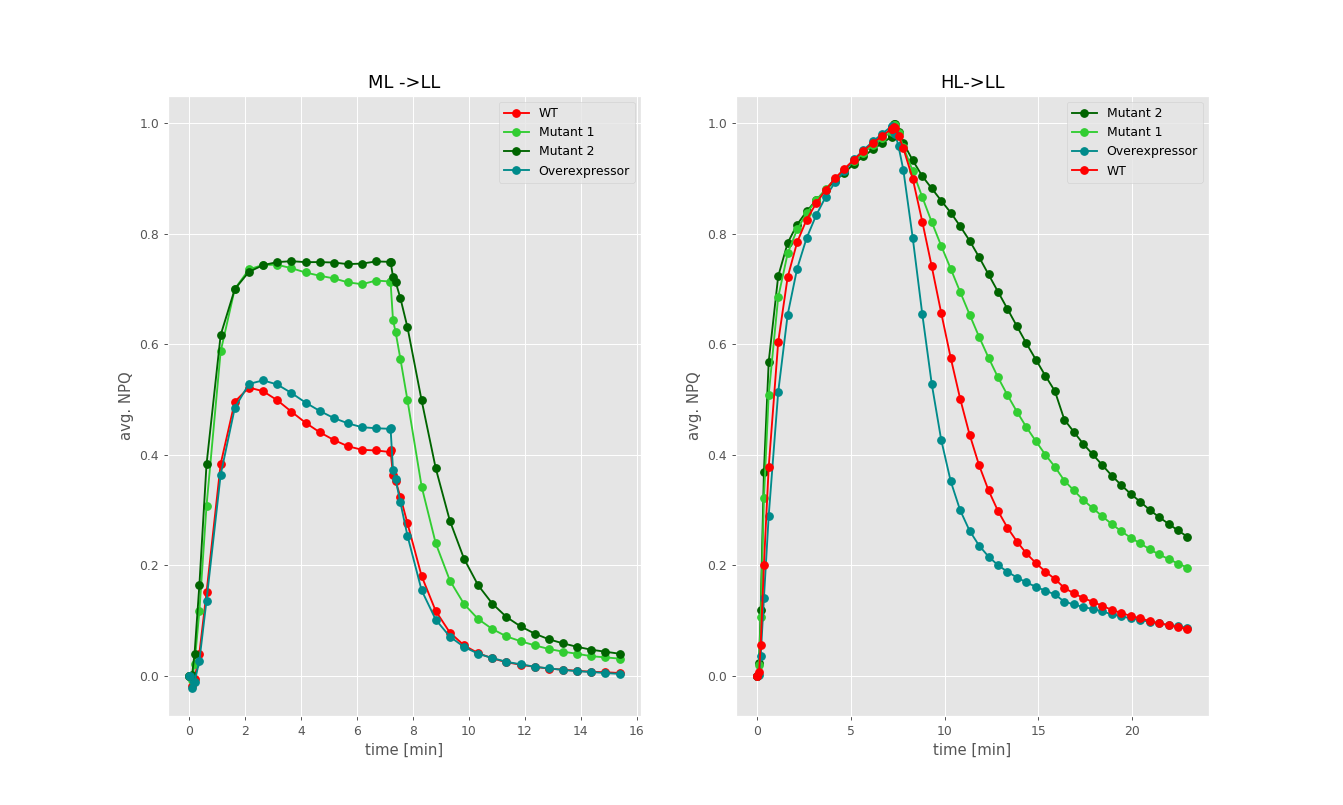

In [208]:
# use pandas iloc, which takes a row/column slice, both based on integer position and following normal python syntax 
# to visualise the data
# data_ml.iloc[::2] takes every second row from the data_ml
plt.figure()
ax1 = plt.subplot(1,2,1)
for i in data_ml.iloc[:,1:8:2].columns: # take avg. data for the first columns which are WT
    plt.plot(data_ml['Unnamed: 0'][3:]/1000./60., data_ml[i][3:], 
             'o-', label=data_ml[i][1], color=colpal[data_ml[i][1]])
    plt.xlabel('time [min]')
    plt.ylabel('avg. NPQ')
plt.title(data_ml[i][0])
plt.legend()
plt.subplot(1,2,2, sharey=ax1)
for i in data_hl.iloc[:,1::4].columns: # take avg. data every 4th column which are WT
    plt.plot(data_hl['Date'][3:]/1000./60., data_hl[i][3:], 
             'o-', label=data_hl[i][1], color=colpal[data_hl[i][1]])
    plt.xlabel('time [min]')
    plt.ylabel('avg. NPQ')
plt.title(data_hl[i][0])
plt.legend()

## Conclusions from the experiments with the control
- WT and overexpressor have very similar NPQ kinetics from ML
- all strains have similar NPQ raise dynamics in HL, but the KEA3 affects the relaxation

IMPORTANT: The NPQ measurements were normalised to NPQmax=2.5

## Parameter set

In [132]:
#Comments from original implementation by Matuszynska et al 2016
pars = {
            
    #Pool sizes 
    'PSIItot': 2.5,  
    'PQtot': 20,     
    'APtot': 50,       
    'Lhcxtot': 1,          
    'Xtot': 1,           
    'O2ex': 8,        
    'Pi': 0.01,             
            
    #Rate constants and key parameters
    'kCytb6f': 0.104,           
                                
    'kActATPase': 0.01,        
    'kDeactATPase': 0.002,     
    'kATPsynthase': 20.,
    'kATPconsumption': 10.,
    'kPQred': 250.,            
    'kH': 5e9,
    'kF': 6.25e8,              # fluorescence 16ns
    'kP': 5e9,                 
    'kPTOX': 0.0,             # CHANGED FOR DIATOM
    'pHstroma': 7.8,           
    'kleak': 1000,
    'bH': 100,                 
    'HPR': 14./3.,
            
    #Parameter associated with xanthophyll cycle
    'kDeepox': 0.0024,
    'kEpox': 0.0024,   
    'KphSatZ': 5.8,      
    'nHX': 5.,           
    'Kzsat': 0.12,       
            
    #Parameter associated with PsbS protonation
    'nHL': 3,
    'kDeprot': 0.0096,
    'kProt': 0.0096,
    'KphSatLHC': 5.8,
            
    #Fitted quencher contribution factors
    'gamma0': 1.0,   
    'gamma1': 0.25,  
    'gamma2': 0.6,   
    'gamma3': 0.15,  
            
    #Physical constants
    'F': 96.485,  
    'R': 8.3e-3,  
    'T': 298,    
            
    #Standard potentials and DG0ATP
    'E0QAQAm': -0.140,
    'E0PQPQH2': 0.354,
    'E0PCPCm': 0.350,  # CHANGED FOR DIATOM
    'DG0ATP': 30.6,  
            
    #PFD
    'PFD': 100

            }

# MODEL

In [209]:
# define the basic model 
M16model = Model(pars)

# add compounds 
M16model.add_compounds([
    "P", # reduced Plastoquinone
    "H", # lumenal Protons
    "E", # ATPactivity to mimic delay of CBB activity in the dark-light transition
    "A", # ATP production
    "Lhcx", # protanated protein, necessary for quenching
    "Dd" # fraction of diadinoxanthin (Ddx) as epoxidised pigment
    ])

## pH and cpfd functions

In [210]:
def cpfdf(PFD):
    """cpfd function for Arabidopsis thaliana"""
    cpfd =  0.0005833 * PFD**2 + 0.2667 * PFD + 187.5
    return cpfd

def calculate_pH(H):
    "assumed bigger lumen by changing the volume"
    return -np.log10(H*3.2e-5)

def calculate_pHstroma(x):
    return (-np.log(x*(3.2e-5))/np.log(10))    

def calculate_pHinv(x):
    return (3.125e4 * 10 **(-x))

## Derived parameters

In [211]:
M16model.add_derived_parameter(
    parameter_name="RT", function=lambda r, t: r * t, parameters=["R", "T"])

def _KeqQAPQ(F, E0QAQAm, E0PQPQH2, pHstroma, RT):
    DG1 =  -F*E0QAQAm 
    DG2 = -2*F*E0PQPQH2 + 2*pHstroma * np.log(10) * RT 
    DG0 = -2*DG1 + DG2
    Keq = np.exp(-DG0/RT)
    return Keq

M16model.add_derived_parameter(
    parameter_name = "KeqQAPQ", function=_KeqQAPQ, parameters=["F", "E0QAQAm", "E0PQPQH2", "pHstroma", "RT"])

## Auxiliary functions

In [212]:
def ps2states(P, Q, light, PQtot, kPQred, KeqQAPQ, kH, kF, kP, PSIItot):
    """Calculates the states of photosystem II
    
    accepts:
    P: reduced fraction of PQ pool (PQH2)
    Q: Quencher
    
    returns:
    B: array of PSII states
    """
    
    Bs = []
    Pox = PQtot - P
    b0 = (light + kPQred*P/KeqQAPQ)
    b1 = (kH * Q + kF)
    b2 = kH * Q + kF + kP
    
    for Pox,b0,b1,b2 in zip(Pox,b0,b1,b2):
        A = np.array([
        [-b0,        b1,         kPQred*Pox,                0], #B0
        [light,     -b2,         0,                         0], #B1
        [0,          0,          light,                   -b1], #B3
        [1,          1,          1,                         1]
        ])
        
        b = np.array([0,0,0,PSIItot])
        B0,B1,B2,B3 = np.linalg.solve(A,b)
        Bs.append([B0, B1, B2, B3])
    return np.array(Bs).T


def Keqcytb6f(H, F, E0PQPQH2, RT, E0PCPCm, pHstroma):
    """Equilibriu constant of Cytochrome b6f"""
    DG1 = -2*F*E0PQPQH2 + 2 * RT * np.log(10) * calculate_pH(H)
    DG2 = -F*E0PCPCm
    DG3 = RT*np.log(10)*(pHstroma - calculate_pH(H))
    DG = -DG1 + 2*DG2 + 2*DG3
    Keq = np.exp(-DG/RT)
    return Keq
    
    
def KeqATPsyn(H, DG0ATP, pHstroma, RT, Pi):
    """Equilibrium constant of ATP synthase. For more
    information see Matuszynska et al 2016 or Ebenhöh et al. 2011,2014
    """
    DG = DG0ATP - np.log(10) * (pHstroma-calculate_pH(H)) * (14/3)  * RT
    Keq = Pi * np.exp(-DG/RT) 
    return Keq

def Fluorescence(P, Q, B0, B2, light, PQtot, kPQred, KeqQAPQ, kH, kF, kP, PSIItot):
    """Fluorescence function"""
    Fluo =  kF/(kH*Q+kF+kP) * B0 + kF/(kH*Q+kF) * B2
    return Fluo

def Quencher(Pr, Dd, H, Xtot, Lhcxtot, Kzsat, gamma0, gamma1, gamma2, gamma3):
    """Quencher mechanism
    
    accepts: 
    Pr: fraction of non-protonated PsbS protein
    V: fraction of Violaxanthin
    """
    Z = Xtot - Dd
    P = Lhcxtot - Pr
    Zs = Z/(Z +  Kzsat)
    
    # v1    
    #Q = gamma0 * (1-Zs) * Pr + gamma1 * (1-Zs) * P + gamma2 * Zs * P + gamma3 * Zs * Pr
    
    #v2
    #Q = gamma0 * (7.8-calculate_pH(H)) * Z
    
    #v3
    Q = gamma0 * Z * P 
    
    
    return Q

## Conserved quantities

In [213]:
def pqmoiety(P, PQtot):
    return [PQtot - P]

def atpmoiety(A, APtot):
    return [APtot - A]

def psbsmoiety(Pr, Lhcxtot):
    return [Lhcxtot - Pr]

def xcycmoiety(Dd, Xtot):
    return [Xtot - Dd]

# Rate equations

In [216]:
def vps2(B1, light, PQtot, kPQred, KeqQAPQ, kH, kF, kP, PSIItot): 
    """Reduction of PQ due to ps2"""
    v = kP * 0.5 * B1
    return v

    
    
def vPQox(P, H, light, kCytb6f, kPTOX, O2ex, PQtot, F, E0PQPQH2, RT, E0PCPCm, pHstroma):
    """Oxidation of the PQ pool through cytochrome and PTOX"""
    kPFD = kCytb6f * light
    kPTOX = kPTOX * O2ex 
    Keq = Keqcytb6f(H, F, E0PQPQH2, RT, E0PCPCm, pHstroma)
    a1 = kPFD * Keq/ (Keq + 1)  
    a2 = kPFD/(Keq + 1)
    v = (a1 + kPTOX) * P - a2 * (PQtot - P)
    return v
    
    
def vATPsynthase(A, H, E, kATPsynthase, DG0ATP, pHstroma, RT, Pi, APtot):
    """Production of ATP by ATPsynthase"""
    v = E * kATPsynthase * (APtot - A - A/KeqATPsyn(H, DG0ATP, pHstroma, RT, Pi))
    return v
    
    
def vATPactivity(E, light,  kActATPase,  kDeactATPase):
    """Activation of ATPsynthase by light"""
    switch = light > 0
    v = kActATPase * switch * (1 - E) - kDeactATPase * (1-switch) * E
    return v
    
    
def vLeak(H, kleak, pHstroma):
    """Transmembrane proton leak"""
    v = kleak * (H - calculate_pHinv(pHstroma))
    return v
    
    
def vATPcons(A, kATPconsumption):
    """ATP consuming reaction"""
    v = kATPconsumption * A
    return v
    
    
def vXdeepox(X, H, nHX, KphSatZ, kDeepoxV, kEpoxZ):
    """Xanthophyll cycle"""
    a = H**nHX / (H**nHX + calculate_pHinv(KphSatZ)**nHX)
    v = kDeepoxV * a * X
    return v

def vXepox(X, H, Xtot, kEpox, nHX, KphSatZ):
    a = H**nHX / (H**nHX + calculate_pHinv(KphSatZ)**nHX)
    return kEpox * (Xtot - X) * (1 - a)
    
    
def vLHCXprot(P, H, nHL, KphSatLHC, kProt):
    """Protonation of PsbS protein"""
    a = H**nHL / (H**nHL + calculate_pHinv(KphSatLHC)**nHL)
    v = kProt * a * P
    return v

def vLHCXdeprot(P, Lhcxtot, kDeprot):
    """Protonation of PsbS protein"""
    return kDeprot * (Lhcxtot - P)

## Algebraic modules

In [217]:
M16model.add_algebraic_module(
    module_name = "P_am",
    function = pqmoiety,
    compounds = ["P"],
    derived_compounds = ["Pox"],
    parameters = ["PQtot"])


M16model.add_algebraic_module(
    module_name = "A_am",
    function = atpmoiety,
    compounds = ["A"],
    derived_compounds = ["ADP"],
    parameters = ["APtot"])


M16model.add_algebraic_module(
    module_name = "PsbS_am",
    function = psbsmoiety,
    compounds = ["Lhcx"],
    derived_compounds = ["Lhcx-p"],
    parameters = ["Lhcxtot"])


M16model.add_algebraic_module(
    module_name = "X_am",
    function = xcycmoiety,
    compounds = ["Dd"],
    derived_compounds = ["Dt"],
    parameters = ["Xtot"])


M16model.add_algebraic_module(
    module_name = "Quencher",
    function = Quencher,
    compounds = ["Lhcx", "Dd", "H"],
    derived_compounds = ["Q"],
    parameters = ["Xtot", "Lhcxtot", "Kzsat",
                  "gamma0", "gamma1", "gamma2",
                  "gamma3"])


M16model.add_algebraic_module(
    module_name = 'PSIIstates',
    function = ps2states,
    compounds = ["P", "Q"],
    derived_compounds = ["B0", "B1", "B2", "B3"],
    parameters = ["PFD", "PQtot", "kPQred",
                  "KeqQAPQ", "kH", "kF", "kP", "PSIItot"])


M16model.add_algebraic_module(
    module_name = "Fluorescence",
    function = Fluorescence,
    compounds = ["P", "Q", "B0", "B2"],
    derived_compounds = ["Fluo"],
    parameters = ['PFD', 'PQtot', 'kPQred', 'KeqQAPQ',
                  'kH', 'kF', 'kP', 'PSIItot'])

M16model.add_algebraic_module(
    module_name = "L",
    function = lambda X, PFD: PFD ,
    compounds = ["P"],
    derived_compounds = ["L"],
    parameters = ['PFD'])

## Add reactions

In [218]:
M16model.add_reaction(
        rate_name = "vps2",
        function = vps2,
        dynamic_variables=["B1"],
        stoichiometry = {"P":1,"H":2/pars["bH"]},
        parameters = ["PFD","PQtot","kPQred", "KeqQAPQ",
                      "kH", "kF", "kP", "PSIItot"])


M16model.add_reaction(
        rate_name = "vPQox",
        function = vPQox,
        dynamic_variables = ['P','H'],
        stoichiometry = {"P":-1,"H":4/pars["bH"]},
        parameters = ["PFD", "kCytb6f", "kPTOX", "O2ex",
                          "PQtot", "F", "E0PQPQH2", "RT", "E0PCPCm",
                          "pHstroma"])

    
M16model.add_reaction(
        rate_name = "vATPsynthase",
        function = vATPsynthase,
        dynamic_variables = ["A","H","E"],
        stoichiometry = {"A":1, "H": (-14/3)/pars["bH"]},
        parameters = ["kATPsynthase", "DG0ATP", "pHstroma",
                      "RT", "Pi", "APtot"])
    
    
M16model.add_reaction(
        rate_name = "vATPactivity",
        function = vATPactivity,
        dynamic_variables = ["E"],
        stoichiometry = {"E":1},
        parameters = ["PFD",  "kActATPase",  "kDeactATPase"])


M16model.add_reaction(
        rate_name = "vLeak",
        function  = vLeak,
        stoichiometry = {"H": -1/pars["bH"]},
        parameters = ["kleak", "pHstroma"])


M16model.add_reaction(
        rate_name = "vATPcons",
        function = vATPcons,
        stoichiometry = {"A":-1},
        parameters = ["kATPconsumption"])


M16model.add_reaction(
        rate_name = "vXdeepox",
        function = vXdeepox,
        dynamic_variables = ['Dd','H'],
        stoichiometry = {"Dd": -1},
        parameters = ["nHX", "KphSatZ", "kDeepox",
                      "kEpox"])

M16model.add_reaction(
        rate_name = "vXepox",
        function = vXepox,
        dynamic_variables = ['Dd', "H"],
        stoichiometry = {"Dd": 1},
        parameters = ["Xtot",
                      "kEpox","nHX", "KphSatZ" ])

M16model.add_reaction(
        rate_name = "vLHCXprot",
        function = vLHCXprot,
        dynamic_variables = ["Lhcx", "H"],
        stoichiometry = {"Lhcx": -1},
        parameters = ["nHL", "KphSatLHC", "kProt"])

M16model.add_reaction(
        rate_name = "vLHCXdeprot",
        function = vLHCXdeprot,
        dynamic_variables = ["Lhcx"],
        stoichiometry = {"Lhcx": 1},
        parameters = ["Lhcxtot",
                      "kDeprot"])


In [219]:
M16model.get_stoichiometric_df()

vATPactivity  vATPcons  vATPsynthase  vLHCXdeprot  vLHCXprot  vLeak  \
A              0.0      -1.0      1.000000          0.0        0.0   0.00   
Dd             0.0       0.0      0.000000          0.0        0.0   0.00   
E              1.0       0.0      0.000000          0.0        0.0   0.00   
H              0.0       0.0     -0.046667          0.0        0.0  -0.01   
Lhcx           0.0       0.0      0.000000          1.0       -1.0   0.00   
P              0.0       0.0      0.000000          0.0        0.0   0.00   

      vPQox  vXdeepox  vXepox  vps2  
A      0.00       0.0     0.0  0.00  
Dd     0.00      -1.0     1.0  0.00  
E      0.00       0.0     0.0  0.00  
H      0.04       0.0     0.0  0.02  
Lhcx   0.00       0.0     0.0  0.00  
P     -1.00       0.0     0.0  1.00

# Fv/Fm
For diatoms between 0.6 and 0.7

In [220]:
y0 =  {"P": 10., "H": 5.56305280e-04, "E": 0., "A": 1., "Lhcx": 1., "Dd": 1.}
Q = M16model.get_full_concentration_dict(y0)['Q']
M16model.update_parameter(    'kP', 1.2e9,  )
fvfm = M16model.get_parameter('kP')/(M16model.get_parameter('kF') + M16model.get_parameter('kP') + M16model.get_parameter('kH')*Q)
print(Q, fvfm)

[0.] [0.65753425]


# Test: reproduce figure 4 from Matuszynka et al. 2016

In [221]:
def get_NPQ(F, t, lights, maxlight=5000):
    r"""Extracts important points of the PAM simuations.

    get_NPQ calculates important points of the PAM simulation such as Fm, Fm', Ft', Fo
    Moreover, the NPQ values are calcuated.

    Parameters
    ----------
    F : numpy.array or list
        Simulated fluorescence values of PAM experiment
    t : numpy.array or list
        Time points of simulated PAM experiment
    lights : numpy.array or list
        PFD values for each time point
    maxlight : int 
       PFD of saturating light impuls
    

    Returns
    -------
    Fm : list
        Fm (first element of list) and Fm' values
    NPQ : list
        Calculated NPQ values
    tm : list
        Exact time points of peaks in PAM trace
    Fo : list
        Fo (first element of list) and Ft' values
    to : list
        Exact time points of Fo and Ft' values
     
    """
    z = [] #container for lists. Each list contains the positions of fluorescence values for one peak 
    o = [] #container for position of Fo'
    cnt = 0
    while cnt < len(lights):
        if lights[cnt] == maxlight:
            h = [] #temporary container for all F==maxlight. For each peak it is renewed
            while cnt != len(lights) and lights[cnt] == maxlight:
                h.append(cnt)
                cnt += 1
            z.append(h)
            o.append(h[0]-1) #value directly at the bottom of peak is Fo
        else:
            cnt += 1
    peaks = [i[np.argmax(F[i])] for i in z] #Fm is the maximal value for each peak sequence
    Fm = F[peaks]
    tm = t[peaks]
    Fo = F[o]
    to = t[o]
    NPQ = (Fm[0] - Fm)/Fm
    return Fm, NPQ, tm, Fo, to   

In [222]:
def grenoblePAM(s, pfd, dT=30, Tmax=15*60):
    dT1 = 15
    t = 0
    while t < 60 :   
        #turn on the saturating pulse of light of Tflash length
        if t%dT1 == 0:
            s.update_parameter('PFD', 10000)
            s.simulate(t+0.8, steps=100)
        else:
            #switch on the light except for the dark period
            s.update_parameter('PFD', pfd)
            new_t = t+dT1-0.8
            s.simulate(new_t, steps=dT1, **{"atol":1.0e-10})  #I needed to make it smaller from the default, otherwise integration problems  
        t = s.get_time()[-1]   

    Tmax=15*60
    dT = 30
    while t < Tmax :   
        #turn on the saturating pulse of light of Tflash length
        if t%dT == 0:
            s.update_parameter('PFD', 10000)
            s.simulate(t+0.8, steps=100)
        else:
            #switch on the light except for the dark period
            #t+dT-Tflash is the time to the next flash
            if t<7*60: #or (t> 16*60 and t<25*60):
                #put the actinic light
                s.update_parameter('PFD', pfd)            
            else:
                s.update_parameter('PFD', 30.)
            new_t = t+dT-0.8
            s.simulate(new_t, steps=dT, **{"atol":1.0e-10})  #I needed to make it smaller from the default, otherwise integration problems  
        t = s.get_time()[-1]           

    # Needs to be normalized s.plot_selection('Fluo')
    F = s.get_variable('Fluo')
    Fm, NPQ, tm, Fo, to = get_NPQ(s.get_variable('Fluo'), s.get_time(), s.get_variable('L'), 10000)
    
    return s, Fm, NPQ, tm, Fo, to, F

In [223]:
y0 =  {"P": 10., "H": 5.56305280e-04, "E": 0., "A": .1, "Lhcx": 1., "Dd": 1.}

<IPython.core.display.Javascript object>


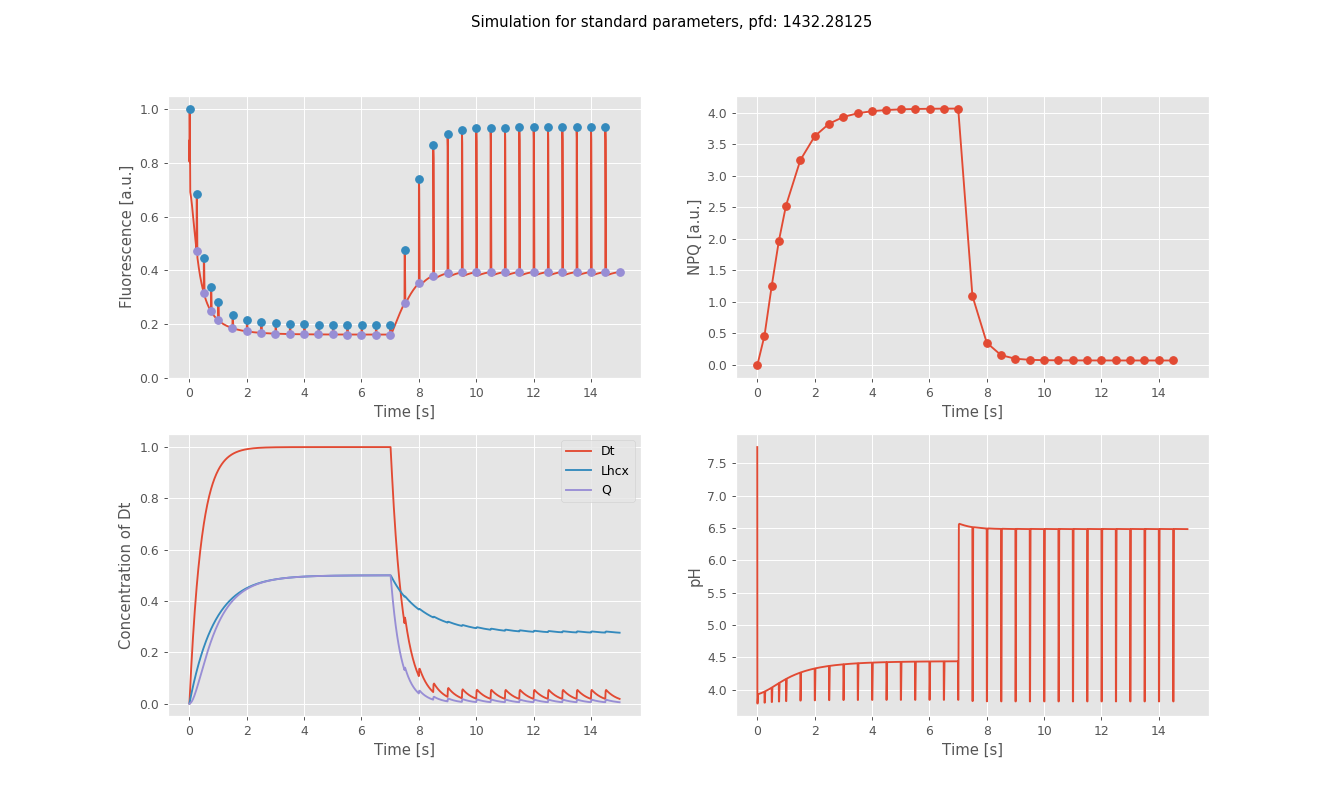

In [224]:
pfd = cpfdf(1250)

s = Simulator(M16model)
#s.update_parameters({
#    'kDeepox': 0.005,
#    'kEpox': 0.0046,
#    'gamma0': 2.,
#    'kActATPase': 0.01,        
#    'kDeactATPase': 0.002,  
#    })


s.update_parameters({
    'kDeepox': 0.04,
    'kEpox': 0.04,
    'gamma0': 1.,
    'kActATPase': 0.01,        
    'kDeactATPase': 0.002,  
    'KphSatZ': 6.0,
    'KphSatLHC': 6.4,
    'nHX': 6,
    'kP': 1.2e9,    
    })

s.initialise(y0)
s, Fm, NPQ, tm, Fo, to, F = grenoblePAM(s, pfd)

#Plots
plt.figure()
ax1=plt.subplot(221)
plt.plot(s.get_time()/60., F/max(F))
plt.plot(tm/60.,Fm[0:]/max(F),'o')
plt.plot(to/60.,Fo/max(F),'o')
plt.ylim(0, 1.05)
plt.xlabel('Time [s]')
plt.ylabel('Fluorescence [a.u.]')

fig2 = plt.subplot(222, sharex=ax1)
plt.plot(tm/60.,NPQ,'o-')
plt.xlabel('Time [s]')
plt.ylabel('NPQ [a.u.]')

fig3 = plt.subplot(223)
plt.plot(s.get_time()/60., s.get_variable('Dt'), label='Dt')
plt.plot(s.get_time()/60., s.get_variable('Lhcx-p'), label='Lhcx')
plt.plot(s.get_time()/60., s.get_variable('Q'), label ='Q')
plt.xlabel('Time [s]')
plt.ylabel('Concentration of Dt')
plt.legend()

fig4 = plt.subplot(224, sharex=fig3)
plt.plot(s.get_time()/60., calculate_pH(s.get_variable('H')))
plt.xlabel('Time [s]')
plt.ylabel('pH')

plt.suptitle('Simulation for standard parameters, pfd: ' + str(pfd))
plt.show()

Run the mutant analysis: left low light
righ tpannel higher light
fluo + npq

<IPython.core.display.Javascript object>


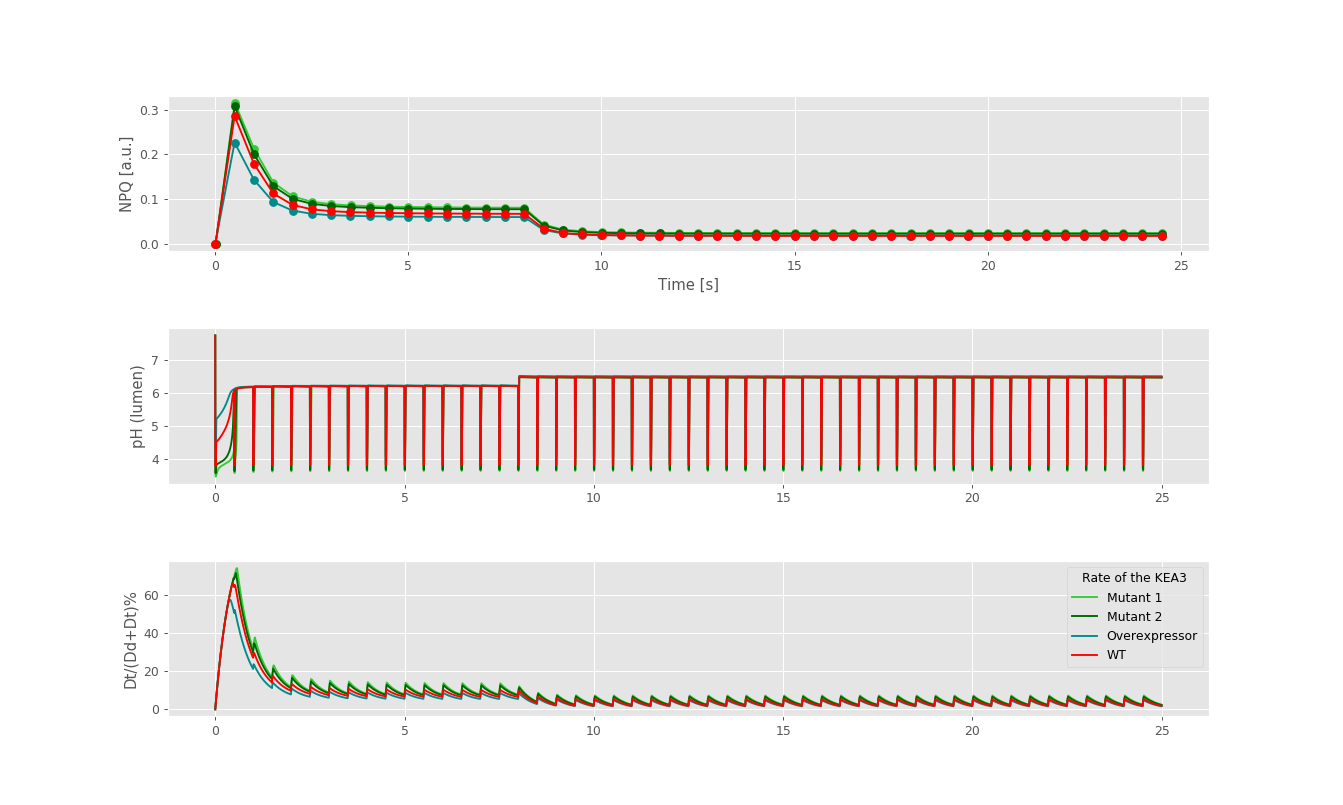

In [225]:
leak_var = {'Mutant 1': 10.,
            'Mutant 2': 100.,
            'Overexpressor': 5000.,
            'WT': 1000.
           }

pfd = cpfdf(125)

dT = 30
Tmax=25*60
cnt = 0

fig, axs = plt.subplots(3, 1, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
axs[0].set_ylabel('NPQ [a.u.]')
axs[1].set_ylabel('pH (lumen)')
axs[2].set_ylabel('Dt/(Dd+Dt)%')


for leak in leak_var.keys():
    s = Simulator(M16model)
    s.initialise(y0)
    
    s.update_parameters({
    'kDeepox': 0.04,
    'kEpox': 0.04,
    'gamma0': 1.,
    'kActATPase': 0.01,        
    'kDeactATPase': 0.002,  
    'KphSatZ': 6.0,
    'KphSatLHC': 6.4,
    'nHX': 6,
    'kP': 1.2e9,    
    })
    
    s.update_parameters({'kleak': leak_var[leak]
                        })

    t = 0.0
    while t < Tmax :   
        #turn on the saturating pulse of light of Tflash length
        if t%dT == 0:
            s.update_parameter('PFD', 10000)
            s.simulate(t+0.8)
        else:
            #switch on the light except for the dark period
            #t+dT-Tflash is the time to the next flash
            if t>8*60:
                s.update_parameter('PFD', 30.)
            else:
                #put the actinic light
                s.update_parameter('PFD', pfd)
            new_t = t+dT-0.8
            s.simulate(new_t, steps=dT, **{"atol":1.0e-10})  #I needed to make it smaller from the default, otherwise integration problems  
        t = s.get_time()[-1]   
    F = s.get_variable('Fluo')
    Fm, NPQ, tm, Fo, to = get_NPQ(s.get_variable('Fluo'), s.get_time(), s.get_variable('L'), 10000)


    axs[0].plot(tm/60., NPQ/4.0,'o-', label=leak, color=colpal[leak])
    axs[0].set_xlabel('Time [s]')


    axs[1].plot(s.get_time()/60., calculate_pH(s.get_variable('H')), label=leak, color=colpal[leak])

    axs[2].plot(s.get_time()/60., s.get_variable('Dt')*100, label=leak, color=colpal[leak])

plt.legend(title='Rate of the KEA3')
plt.show()

## Second mechanism: dependancy on the pH

Now change the quencher function to be proportional only to the Dt, but the strenth will depend on the pH

    Q = gamma0 * (7.8-calculate_pH(H)) * Z

In [ ]:
s2 = Simulator(M16model)
s2.initialise(y0)
grenoblePAM(s2, 125)

#Plots
plt.figure()
ax1=plt.subplot(221)
plt.plot(s.get_time()/60., F/max(F))
plt.plot(tm/60.,Fm[0:]/max(F),'o')
plt.plot(to/60.,Fo/max(F),'o')
plt.ylim(0, 1.05)
plt.xlabel('Time [s]')
plt.ylabel('Fluorescence [a.u.]')

fig2 = plt.subplot(222, sharex=ax1)
plt.plot(tm/60.,NPQ/1.5,'o-')
plt.xlabel('Time [s]')
plt.ylabel('NPQ [a.u.]')

fig3 = plt.subplot(223)
plt.plot(s.get_time()/60., s.get_variable('Dt'), label='Dt')
plt.plot(s.get_time()/60., s.get_variable('Lhcx-p'), label='Lhcx')
plt.plot(s.get_time()/60., s.get_variable('Q'), label ='Q')
plt.xlabel('Time [s]')
plt.ylabel('Concentration of Dt')
plt.legend()

fig4 = plt.subplot(224, sharex=fig3)
plt.plot(s.get_time()/60., calculate_pH(s.get_variable('H')))
plt.xlabel('Time [s]')
plt.ylabel('pH')

plt.suptitle('Simulation for standard parameters, pfd: ' + str(pfd))
#plt.show()

## Third mechanism: composition of two components
Now change the quencher function to be proportional only to the Dt, but the strenth will depend on the pH

    Q = Dt * Lhcx-p

In [ ]:
pfd = 500
s3 = Simulator(M16model)
s3.initialise(y0)
grenoblePAM(s3, pfd)

#Plots
plt.figure()
ax1=plt.subplot(221)
plt.plot(s3.get_time()/60., F/max(F))
plt.plot(tm/60.,Fm[0:]/max(F),'o')
plt.plot(to/60.,Fo/max(F),'o')
plt.ylim(0, 1.05)
plt.xlabel('Time [s]')
plt.ylabel('Fluorescence [a.u.]')

fig2 = plt.subplot(222, sharex=ax1)
plt.plot(tm/60.,NPQ/1.5,'o-')
plt.xlabel('Time [s]')
plt.ylabel('NPQ [a.u.]')

fig3 = plt.subplot(223)
plt.plot(s3.get_time()/60., s3.get_variable('Dt'), label='Dt')
plt.plot(s3.get_time()/60., s3.get_variable('Lhcx-p'), label='Lhcx')
plt.plot(s3.get_time()/60., s3.get_variable('Q'), label ='Q')
plt.xlabel('Time [s]')
plt.ylabel('Concentration of Dt')
plt.legend()

fig4 = plt.subplot(224, sharex=fig3)
plt.plot(s3.get_time()/60., calculate_pH(s3.get_variable('H')))
plt.xlabel('Time [s]')
plt.ylabel('pH')

plt.suptitle('Simulation for standard parameters, pfd: ' + str(pfd))
plt.show()

Same model for the quencher but with changed kinetic parameters

In [ ]:
pfd = 1250

s = Simulator(M16model)


s.update_parameters({
    'kDeepox': 0.01,
    'kEpox': 0.006, })

s.initialise(y0)

s, Fm, NPQ, tm, Fo, to, F = grenoblePAM(s, pfd)



#Plots
plt.figure()
ax1=plt.subplot(221)
plt.plot(s.get_time()/60., F/max(F))
plt.plot(tm/60.,Fm[0:]/max(F),'o')
plt.plot(to/60.,Fo/max(F),'o')
plt.ylim(0, 1.05)
plt.xlabel('Time [s]')
plt.ylabel('Fluorescence [a.u.]')

fig2 = plt.subplot(222, sharex=ax1)
plt.plot(tm/60.,NPQ/1.5,'o-')
plt.xlabel('Time [s]')
plt.ylabel('NPQ [a.u.]')

fig3 = plt.subplot(223)
plt.plot(s.get_time()/60., s.get_variable('Dt'), label='Dt')
plt.plot(s.get_time()/60., s.get_variable('Lhcx-p'), label='Lhcx')
plt.plot(s.get_time()/60., s.get_variable('Q'), label ='Q')
plt.xlabel('Time [s]')
plt.ylabel('Concentration of Dt')
plt.legend()

fig4 = plt.subplot(224, sharex=fig3)
plt.plot(s.get_time()/60., calculate_pH(s.get_variable('H')))
plt.xlabel('Time [s]')
plt.ylabel('pH')

plt.suptitle('Simulation for standard parameters, pfd: ' + str(pfd))
#plt.show()